# PS bunch generation: LIU 2021, 2022, 2023 Ramp-Up
# N.B. Python 3.0

In [1]:
# General imports
%matplotlib notebook
import sys
import numpy as np
import scipy.io as sio
from scipy.io import savemat
from math import log10, floor
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density

In [2]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def replace_point_with_p(input_str):
    return input_str.replace(".", "p")

## BLonD Simulation 

In [3]:
# Case selection
n_macroparticles = 5E5
beam_selection = 'Standard'
year_selection = 2023

# PS ring parameters
circumference = 628.3185 # 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 2e9
#gamma_t = 6.1
gamma_t = 6.08378627 #2 GeV

if beam_selection == 'Standard':
    # PS rf parameters Standard
    rf_harmonic = 7

    if year_selection == 2021:
        # PS bunch parameters Standard
        rf_voltage = 42.25e3
        #rf_voltage = 35e3
        particle_type = Proton()
        full_bunch_length = 135e-9
        # full_emittance = 1.50
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2022:
        # PS bunch parameters Standard
        rf_voltage = 42.60e3
        particle_type = Proton()
        full_bunch_length = 170e-9
        # full_emittance = 2.25
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2023:
        # PS bunch parameters Standard
        rf_voltage = 41.80e3
        particle_type = Proton()
        full_bunch_length = 205e-9
        # full_emittance = 3.00
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

# elif beam_selection == 'BCMS':
#     # PS rf parameters BCMS
#     rf_harmonic = 9
#     rf_voltage = 36.55e3

#     # PS bunch parameters BCMS
#     particle_type = Proton()
#     full_bunch_length = 135e-9
#     # full_emittance = 1.48
#     bunch_intensity = 16.25e11
#     line_density_type='parabolic_line'
    
    #Beta = 0.947643035549 #PyORBIT 0.9476444679333867 #2 GeV
    Beta = 0.9476430317778735 #PTC 0.9476444679333867 #2 GeV
    E = 2.938237191E9 # 2 GeV

    #dpp_rms = round_sig(np.std(np.array(beam.dE))/E/Beta**2,5)
    #print('dpp_RMS = ',round_sig(dpp_rms,5))

In [4]:
gamma_ptc = 3.131540798
beta_ptc = np.sqrt(1 - 1/(gamma_ptc**2))
print (beta_ptc)

0.9476430317778735


In [5]:
# Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam,
                                        TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]

# Conversion
particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)
particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c


In [6]:
# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],
                   output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outter bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]),
                     np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)



## Calculate dpp_RMS

In [7]:
# Calculate delta_p/p RMS

# 2021
# gamma_t = 6.1          dpp_rms = 0.0012355
# gamma_t = 6.08378627   dpp_rms = 0.0012369

# 2023
# gamma_t = 6.1          dpp_rms = 0.0017115  # Should be 1.5E-3
# gamma_t = 6.08378627   dpp_rms = 0.0017111

#Beta = 0.915839281848 #1.4GeV
#E = 2336654575.29 # 1.4 GeV
Beta = 0.9476444679333867 #2 GeV
E = 2.938237E9 # 2 GeV

dpp_rms = np.std(np.array(beam.dE))/E/Beta**2
print('dpp_RMS = ',round_sig(dpp_rms,5))

dpp_RMS =  0.0017106


## Calculate Emittance

In [8]:
eps_z = np.std(np.array(beam.dE)) * np.std(np.array(beam.dt)) * np.pi
print ('eps_z = ', eps_z)

eps_z =  0.6488151806073179


## Find bucket height

In [9]:
def RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor):
    return ((2*np.pi*Radius)/(np.pi*harmonic*299792458)) * np.sqrt( ( (- 1.602E-19 * V_RF * E_0)/(2 * np.pi * harmonic * slip_factor) ) )  
    
def RF_bucket_positive_limit(phase, Radius, V_RF, E_0, harmonic, slip_factor):
    return (RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor) * np.sin(phase/2))

def Generate_RF_bucket(Radius, V_RF, E_0, harmonic, slip_factor):
    x_dat = np.linspace(0,(2*np.pi),100)
    y_dat = []
    for i in x_dat:
        y_dat.append(RF_bucket_positive_limit(i, Radius, V_RF, E_0, harmonic, slip_factor))
        
    return y_dat

def calc_slip_factor_from_gammas(gamma_tr, gamma_0):
    return( (1/(gamma_tr*gamma_tr)) - (1/(gamma_0*gamma_0)) )

slip_factor =  -0.07495473683903535
V_RF =  41800.0
W_bf =  1.9209104980675678e-10
Bucket area = 8 * W_bf  1.5367283984540543e-09


<IPython.core.display.Javascript object>


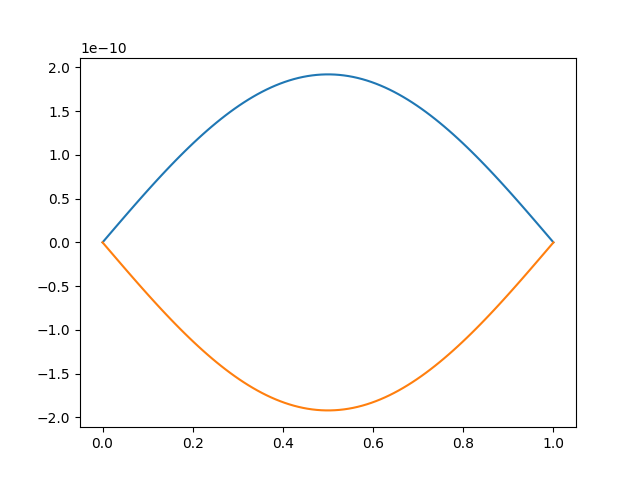

In [10]:
# From PTC for LIU 2021
gamma_0 = 3.131541
gamma_transition = 6.083786
eta_c = -0.074955
# Check slip factor
slip_factor = calc_slip_factor_from_gammas(gamma_transition, gamma_0)
print('slip_factor = ', slip_factor)

Radius = 628.318500/(2*np.pi)
V_RF = rf_voltage
print('V_RF = ', V_RF)
E_0 = kinetic_energy 
harmonic = 7
# Divide by bunch length?

W_bf = RF_bucket_height(Radius, V_RF, E_0, harmonic, slip_factor)
print('W_bf = ', W_bf)

print('Bucket area = 8 * W_bf ', 8*W_bf)

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)
x_dat = np.linspace(0,(2*np.pi),100)
y_dat = Generate_RF_bucket(Radius, V_RF, E_0, harmonic, slip_factor)
y_dat = np.array(y_dat)
y_dat_2 = -1*np.array(y_dat)
ax1.plot(x_dat/(2*np.pi), y_dat)
ax1.plot(x_dat/(2*np.pi), y_dat_2)


## Plot 

<IPython.core.display.Javascript object>


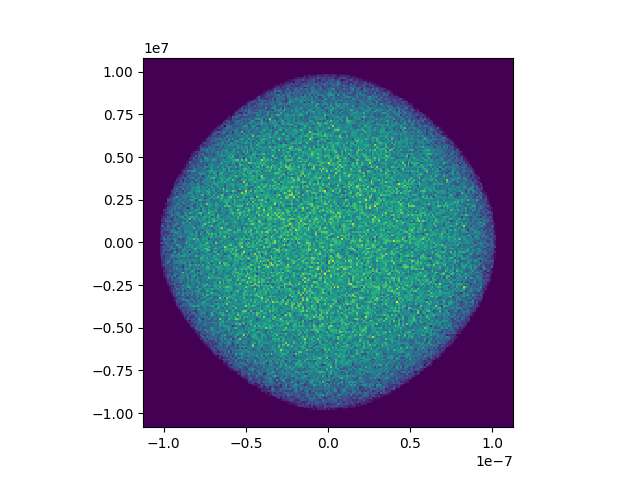

In [11]:
# First we need to make the data into a 2D array

# Start with our data
dE = np.array(beam.dE)
dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

bin_size_x = 200
bin_size_y = 200
x_min = np.min(dt)*1.1
x_max = np.max(dt)*1.1
y_min = np.min(dE)*1.1
y_max = np.max(dE)*1.1

# Need a heatmap to make a 2D array:
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )

<IPython.core.display.Javascript object>


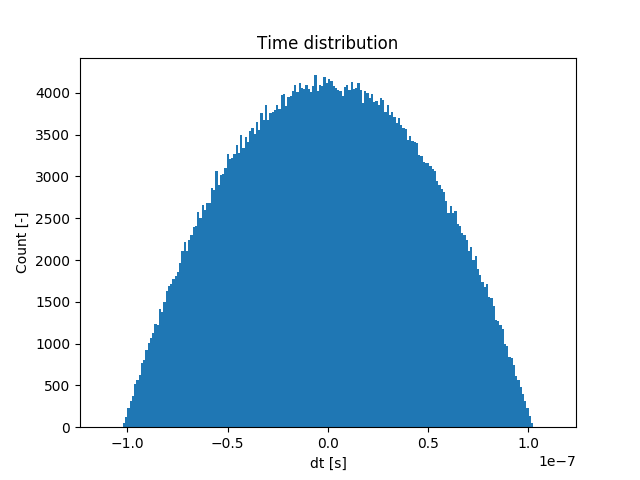

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dt [s]'),
 Text(0.5, 1.0, 'Time distribution')]

In [12]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dt, bins = bin_size_x, range=[x_min, x_max])
plt.hist(dt, bins = bin_size_x, range=[x_min, x_max])

ax1.set(xlabel='dt [s]', ylabel='Count [-]', title='Time distribution')

<IPython.core.display.Javascript object>


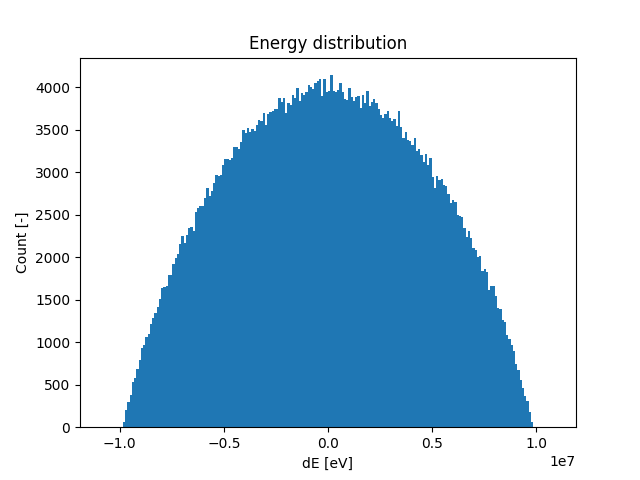

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dE [eV]'),
 Text(0.5, 1.0, 'Energy distribution')]

In [13]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dE, bins = bin_size_y, range=[y_min, y_max])
plt.hist(dE, bins = bin_size_y, range=[y_min, y_max])

ax1.set(xlabel='dE [eV]', ylabel='Count [-]', title='Energy distribution')

## Write tomo-style input file for PyORBIT

In [14]:
# We want this in units of MeV and ns
data = heatmap
data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': data}
fname = str('PyORBIT_Tomo_file_LIU_Ramp_Up_' + beam_selection +'_'+ str(year_selection) + '.mat')
savemat(fname, data_dict)

<IPython.core.display.Javascript object>


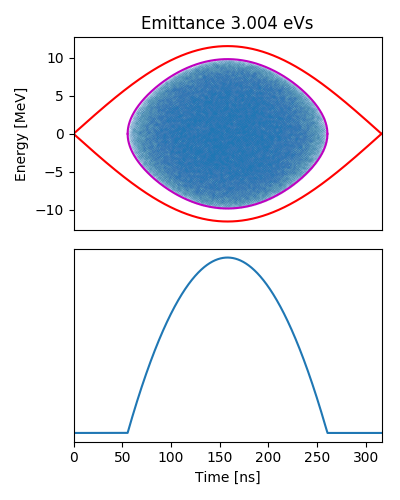

In [15]:
# Output figure

plt.figure('Beam', figsize=(4,5))
plt.clf()

plt.subplot(211)
plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
         markersize=0.1, alpha=0.2)
plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Energy [MeV]')
plt.title('Emittance %.3f eVs'%(calc_area_bunch))

plt.subplot(212)
plt.plot(output_profile[0]*1e9, output_profile[1])
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Time [ns]')

plt.tight_layout()
plt.savefig('figure_'+str(beam_selection)+'.png')



## Dump particle co-ordinates to read in PyORBIT

In [16]:
# Saving distribution

particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)

particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c

np.savez('BLonD_Longitudinal_Distn_LIU_2023_41p8kV.npz',
         dt=(beam.dt - rf_station.t_rf[0,0]/2.),
         dz=particle_z,
         dE=beam.dE)



## Check loading of file etc

In [17]:
Check_Output_File = False

In [18]:
# Open BLonD file
if Check_Output_File:
    BLonD_data = np.load('BLonD_Longitudinal_Distn_LIU_2023_41p8kV.npz')

In [19]:
if Check_Output_File:
    BLonD_data['dz']

In [20]:
if Check_Output_File:
    BLonD_data['dE']

In [21]:
if Check_Output_File:
    # Iterate through particles
    n_part = int(2E3)
    z = np.zeros(int(1E3))
    dE = np.zeros(int(1E3))
    for i in range(n_part):
        try:
            # Set co-ordinates
            z[i] = BLonD_data['dz'][i]
            dE[i] = (BLonD_data['dE'][i] / 1E9) # in eV
        except IndexError:
            print('IndexError at value ', i)
            break

In [22]:
if Check_Output_File:
    z[999]

## Check distribution created in PyORBIT

In [5]:
def add_PyORBIT_bunch_file(dd, filename, label):
	f = filename
	p = sio.loadmat(f, squeeze_me=True,  struct_as_record=False)['particles']
	dd[label] = p
	print ('\tAdded output data from ', filename, '\t dictionary key: ', label)
	return dd

In [6]:
def add_PyORBIT_output_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print ('\tAdded output data from ', filename, '\t dictionary key: ', label)
	return dd

In [7]:
dd = dict()

dd = add_PyORBIT_bunch_file(dd, 'NoSC_Initial_Distn.mat', 'NoSC_Initial')

	Added output data from  NoSC_Initial_Distn.mat 	 dictionary key:  NoSC_Initial


<IPython.core.display.Javascript object>


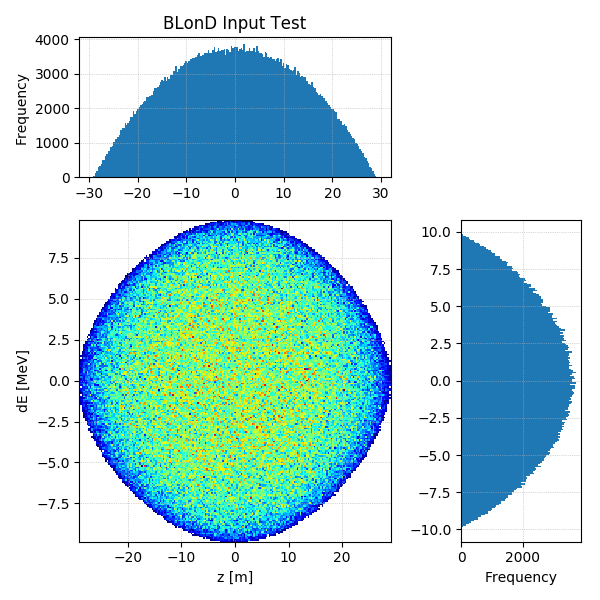

In [8]:
f, ax = plt.subplots(1, figsize=(6,6))
gridspec.GridSpec(3,3)
#f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

bin_size = 200

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)

title = 'BLonD Input Test' 

z = dd['NoSC_Initial'].z
dE = dd['NoSC_Initial'].dE*1E3 #dE in GeV

# First subplot
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
plt.title(title)
plt.ylabel('Frequency')
plt.grid(which='both', ls=':', lw=0.5)
#plt.xlim(-30, 30)

# Main plot
plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
plt.xlabel('z [m]')
plt.ylabel('dE [MeV]')
plt.grid(which='both', ls=':', lw=0.5)
#plt.xlim(-30, 30)
#plt.ylim(-10, 10)

# Second subplot
plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
plt.xlabel('Frequency')
plt.grid(which='both', ls=':', lw=0.5)
#plt.ylim(-10, 10)

current_axis = plt.gca()
#current_axis.axes.get_yaxis().set_visible(False)

#ax.xaxis.label.set_size(fontsize)
#ax.yaxis.label.set_size(fontsize)

#ax.tick_params(labelsize=fontsize)

plt.tight_layout()
savename = 'PyORBIT.png'
f.savefig(savename, dpi=500)

<IPython.core.display.Javascript object>


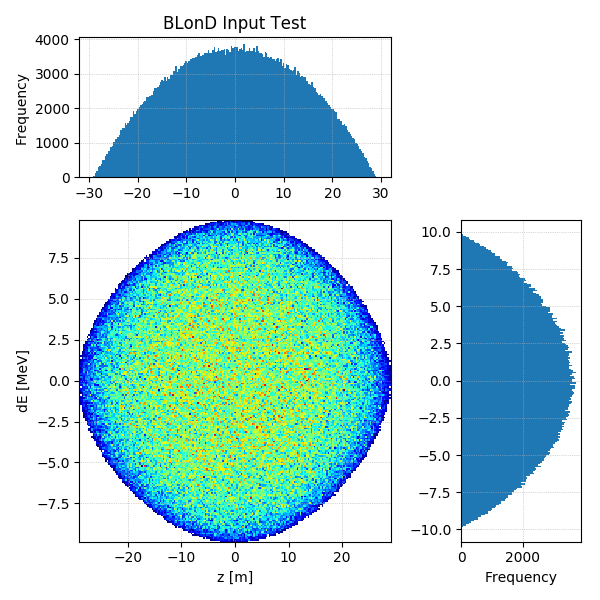

In [64]:
f, ax = plt.subplots(1, figsize=(6,6))
gridspec.GridSpec(3,3)
#f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

bin_size = 200

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)

title = 'BLonD Input Test' 

z = particle_z
dE = beam.dE/1E6

# First subplot
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
plt.title(title)
plt.ylabel('Frequency')
plt.grid(which='both', ls=':', lw=0.5)
#plt.xlim(-30, 30)

# Main plot
plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
plt.xlabel('z [m]')
plt.ylabel('dE [MeV]')
plt.grid(which='both', ls=':', lw=0.5)
#plt.xlim(-30, 30)
#plt.ylim(-10, 10)

# Second subplot
plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
plt.xlabel('Frequency')
plt.grid(which='both', ls=':', lw=0.5)
#plt.ylim(-10, 10)

current_axis = plt.gca()
#current_axis.axes.get_yaxis().set_visible(False)

#ax.xaxis.label.set_size(fontsize)
#ax.yaxis.label.set_size(fontsize)

#ax.tick_params(labelsize=fontsize)

plt.tight_layout()
savename = 'BLonD.png'
f.savefig(savename, dpi=500)

## Check test outputs 

In [38]:
dd1 = dict()

dd1 = add_PyORBIT_output_file(dd1, '../00/output/output.mat', 'NoSC')
dd1 = add_PyORBIT_output_file(dd1, '../10/output/output.mat', 'SC')
dd1 = add_PyORBIT_output_file(dd1, '../../13_Phase_Check/00_03/output/output.mat', 'Old NoSC')
dd1 = add_PyORBIT_output_file(dd1, '../../13_Phase_Check/01_03/output/output.mat', 'Old SC')

	Added output data from  ../00/output/output.mat 	 dictionary key:  NoSC
	Added output data from  ../10/output/output.mat 	 dictionary key:  SC
	Added output data from  ../../13_Phase_Check/00_03/output/output.mat 	 dictionary key:  Old NoSC
	Added output data from  ../../13_Phase_Check/01_03/output/output.mat 	 dictionary key:  Old SC


In [39]:
dd1['SC'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'eps_z', 'D_x', 'D_y', 'mu_y', 'kurtosis_yp_6sig', 'kurtosis_yp', 'kurtosis_y', 'intensity', 'mu_yp', 'kurtosis_z_6sig', 'min_yp', 'cumulative_time', 'eff_beta_y', 'eff_beta_x', 'kurtosis_y_6sig', 'kurtosis_x', 'min_x', 'mu_z', 'epsn_y', 'epsn_x', 'beta_y', 'beta_x', 'max_xp', 'mean_yp', 'sig_dE', 'dpp_rms', 'kurtosis_xp', 'eff_epsn_y', 'eff_epsn_x', 'mean_x', 'mean_y', 'mean_z', 'min_dE', 'kurtosis_x_6sig', 'max_z', 'mu_dE', 'max_x', 'max_y', 'n_mp', 'mean_dE', 'min_y', 'kurtosis_xp_6sig', 'sig_yp', 'sig_y', 'sig_x', 'min_xp', 'max_yp', 'kurtosis_z', 'eff_alpha_x', 'eff_alpha_y', 'mu_xp', 'turn_time', 'alpha_x', 'alpha_y', 'mean_xp', 'bunchlength', 'turn_duration', 'sig_z', 'kurtosis_dE', 'mu_x', 'turn', 'sig_xp', 'max_dE', 'kurtosis_dE_6sig', 'min_z', 'gamma'])

In [40]:
# Access like
dd1['SC']['turn'][0]

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [91]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

<IPython.core.display.Javascript object>


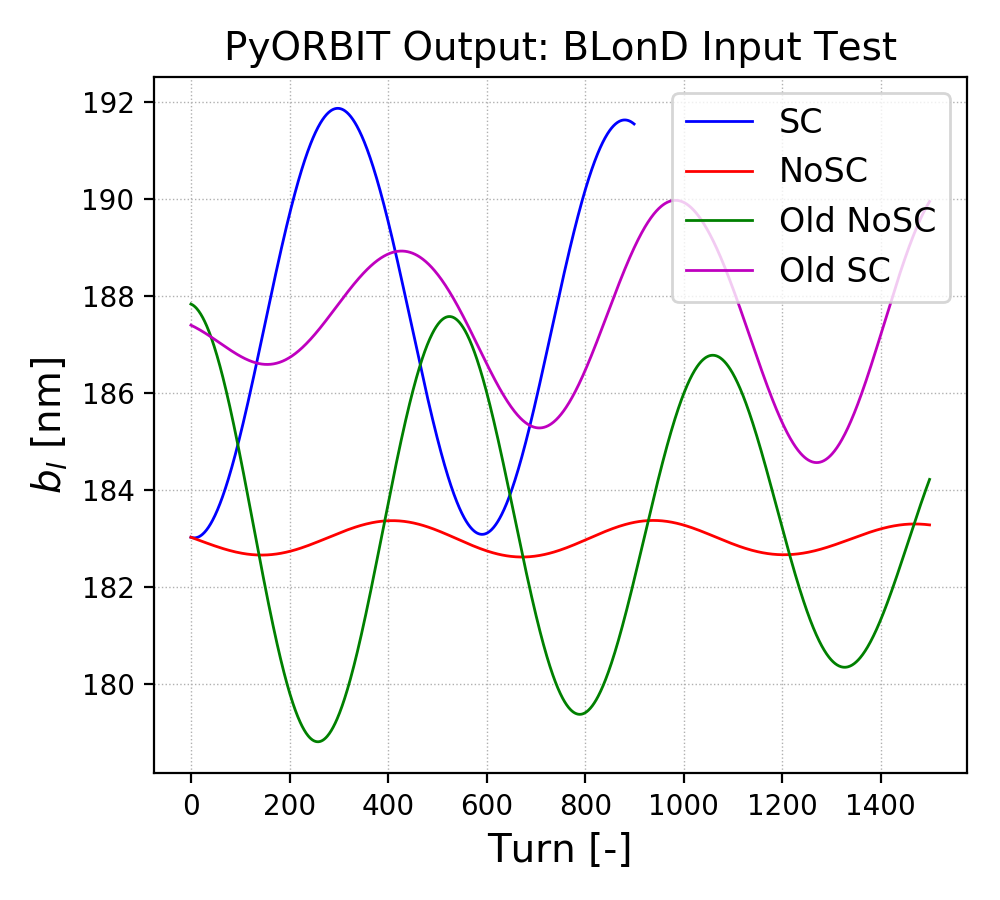

In [92]:
parameter1 = 'bunchlength'
multi1 = 1E9

fig, ax1 = plt.subplots();
ax1.set_title('PyORBIT Output: BLonD Input Test')

savename = parameter1 + '.png'

ax1.set_xlabel('Turn [-]')
ax1.set_ylabel('$b_l$ [nm]')
    
ax1.plot(dd1['SC']['turn'][0], dd1['SC'][parameter1][0]*multi1, color='b', label='SC');
ax1.plot(dd1['NoSC']['turn'][0], dd1['NoSC'][parameter1][0]*multi1, color='r', label='NoSC');
ax1.plot(dd1['Old NoSC']['turn'][0], dd1['Old NoSC'][parameter1][0]*multi1, color='g', label='Old NoSC');
ax1.plot(dd1['Old SC']['turn'][0], dd1['Old SC'][parameter1][0]*multi1, color='m', label='Old SC');


ax1.legend(loc=1)
ax1.grid(which='both', ls=':', lw=0.5)

plt.tight_layout()
fig.savefig(savename)

In [86]:
print ('V = 41.8 kV LIU 2021')
print ('\nNoSC average bunch length = ', round_sig(np.mean(dd1['NoSC']['bunchlength'][0])*1E9, 4), 'nm')
print ('Old NoSC average bunch length = ', round_sig(np.mean(dd1['Old NoSC']['bunchlength'][0])*1E9, 4), 'nm')
print ('\nSC average bunch length = ', round_sig(np.mean(dd1['SC']['bunchlength'][0])*1E9, 4), 'nm')
print ('Old SC average bunch length = ', round_sig(np.mean(dd1['Old SC']['bunchlength'][0])*1E9, 4), 'nm')
print ('\nSpace charge increase of ', -1*round_sig(1 -(np.mean(dd1['SC']['bunchlength'][0]) / np.mean(dd1['NoSC']['bunchlength'][0])), 4)*100, '%')

V = 41.8 kV LIU 2021

NoSC average bunch length =  183.0 nm
Old NoSC average bunch length =  183.1 nm

SC average bunch length =  187.5 nm
Old SC average bunch length =  187.3 nm

Space charge increase of  2.481 %


<IPython.core.display.Javascript object>


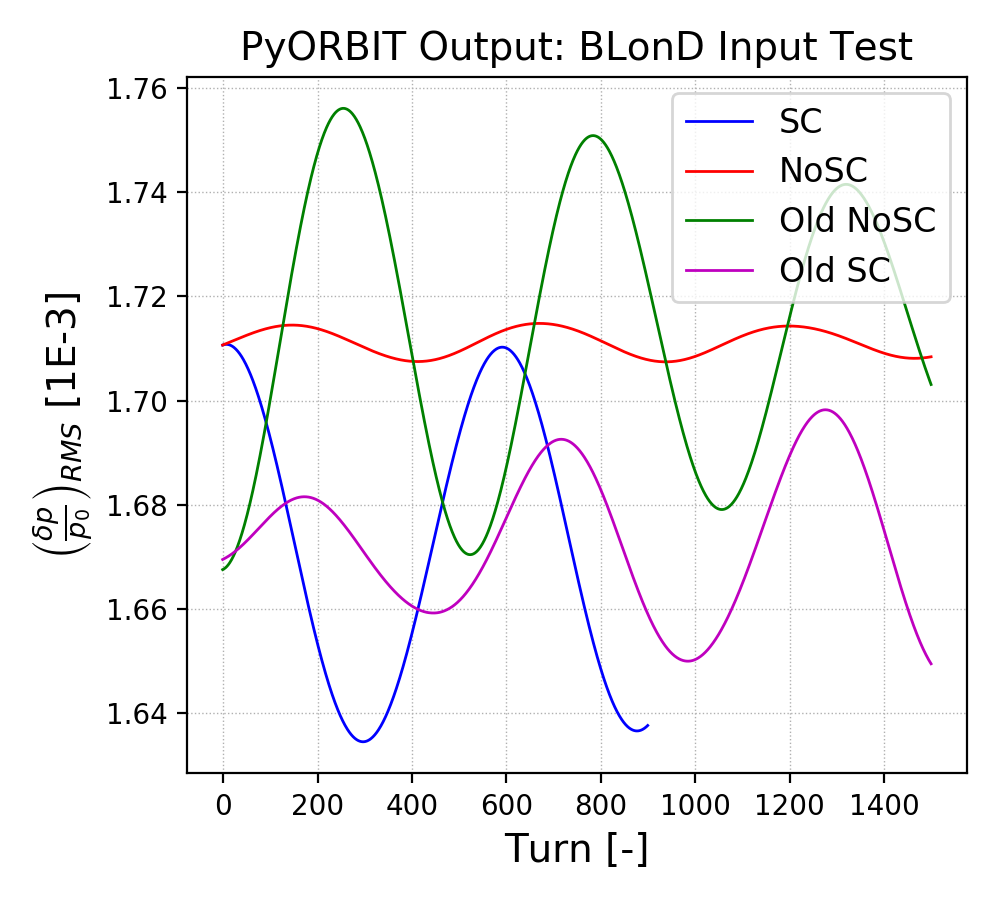

In [93]:
parameter1 = 'dpp_rms'
multi1 = 1E3

fig, ax1 = plt.subplots();
ax1.set_title('PyORBIT Output: BLonD Input Test')

savename = parameter1 + '.png'

ax1.set_xlabel('Turn [-]')
ax1.set_ylabel(r'$ \left( \frac{\delta p}{p_0} \right)_{RMS}$ [1E-3]')
    
ax1.plot(dd1['SC']['turn'][0], dd1['SC'][parameter1][0]*multi1, color='b', label='SC');
ax1.plot(dd1['NoSC']['turn'][0], dd1['NoSC'][parameter1][0]*multi1, color='r', label='NoSC');
ax1.plot(dd1['Old NoSC']['turn'][0], dd1['Old NoSC'][parameter1][0]*multi1, color='g', label='Old NoSC');
ax1.plot(dd1['Old SC']['turn'][0], dd1['Old SC'][parameter1][0]*multi1, color='m', label='Old SC');


ax1.legend(loc=1)
ax1.grid(which='both', ls=':', lw=0.5)

plt.tight_layout()
fig.savefig(savename)

In [88]:
print ('V = 41.8 kV LIU 2021')
print ('\nNoSC average dpp_rms = ', round_sig(np.mean(dd1['NoSC']['dpp_rms'][0])*1E3, 4), 'E-3')
print ('Old NoSC average dpp_rms = ', round_sig(np.mean(dd1['Old NoSC']['dpp_rms'][0])*1E3, 4), 'E-3')
print ('\nSC average dpp_rms = ', round_sig(np.mean(dd1['SC']['dpp_rms'][0])*1E3, 4), 'E-3')
print ('Old SC average dpp_rms = ', round_sig(np.mean(dd1['Old SC']['dpp_rms'][0])*1E3, 4), 'E-3')
print ('\nSpace charge decrease of ', round_sig(1 - (np.mean(dd1['SC']['dpp_rms'][0]) / np.mean(dd1['NoSC']['dpp_rms'][0])), 4)*100, '%')

V = 41.8 kV LIU 2021

NoSC average dpp_rms =  1.711 E-3
Old NoSC average dpp_rms =  1.714 E-3

SC average dpp_rms =  1.672 E-3
Old SC average dpp_rms =  1.673 E-3

Space charge decrease of  2.29 %


<IPython.core.display.Javascript object>


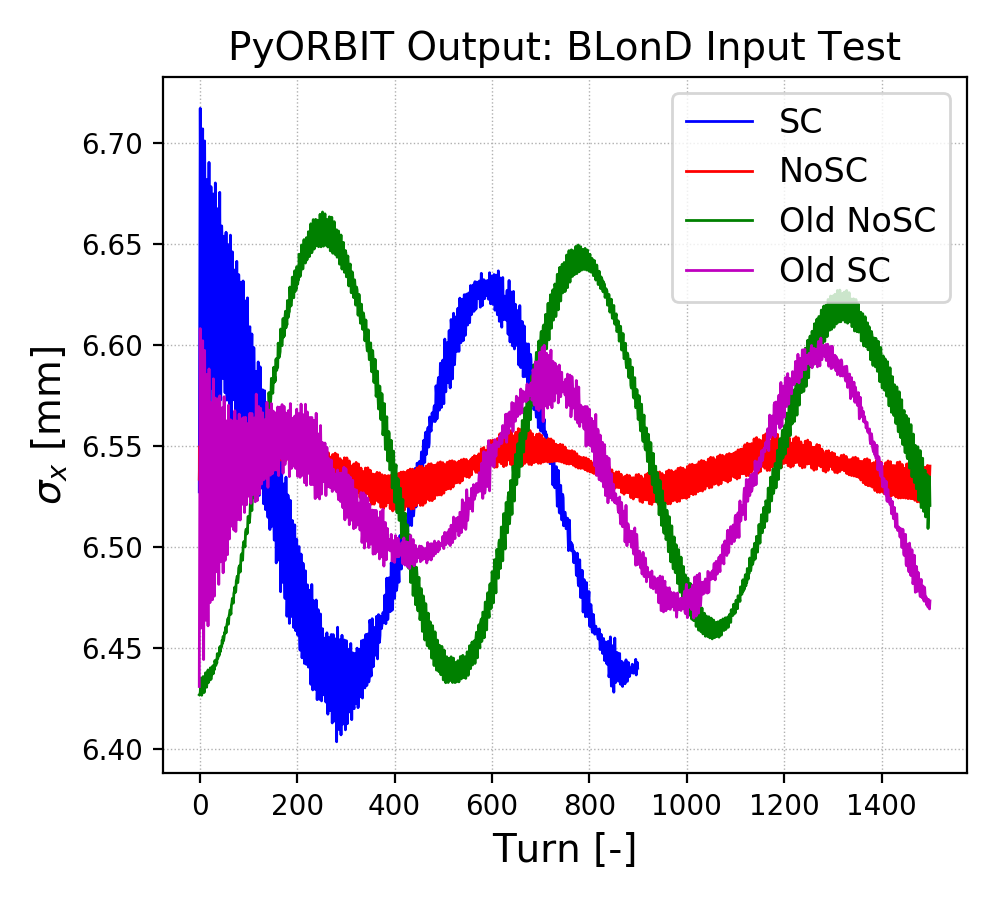

In [94]:
parameter1 = 'sig_x'
multi1 = 1E3

fig, ax1 = plt.subplots();
ax1.set_title('PyORBIT Output: BLonD Input Test')

savename = parameter1 + '.png'

ax1.set_xlabel('Turn [-]')
ax1.set_ylabel('$\sigma_x$ [mm]')
    
ax1.plot(dd1['SC']['turn'][0], dd1['SC'][parameter1][0]*multi1, color='b', label='SC');
ax1.plot(dd1['NoSC']['turn'][0], dd1['NoSC'][parameter1][0]*multi1, color='r', label='NoSC');
ax1.plot(dd1['Old NoSC']['turn'][0], dd1['Old NoSC'][parameter1][0]*multi1, color='g', label='Old NoSC');
ax1.plot(dd1['Old SC']['turn'][0], dd1['Old SC'][parameter1][0]*multi1, color='m', label='Old SC');


ax1.legend(loc=1)
ax1.grid(which='both', ls=':', lw=0.5)

plt.tight_layout()
fig.savefig(savename)

<IPython.core.display.Javascript object>


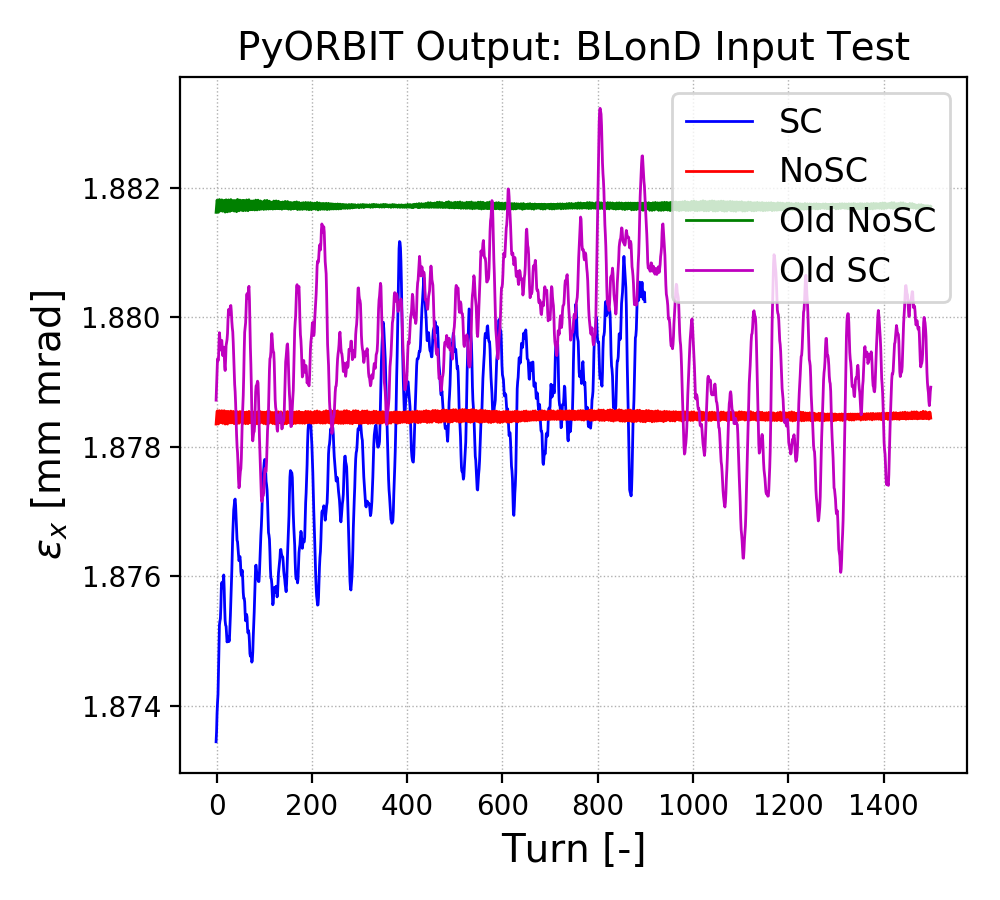

In [96]:
parameter1 = 'epsn_x'
multi1 = 1E6

fig, ax1 = plt.subplots();
ax1.set_title('PyORBIT Output: BLonD Input Test')

savename = parameter1 + '.png'

ax1.set_xlabel('Turn [-]')
ax1.set_ylabel('$\epsilon_x$ [mm mrad]')
    
ax1.plot(dd1['SC']['turn'][0], dd1['SC'][parameter1][0]*multi1, color='b', label='SC');
ax1.plot(dd1['NoSC']['turn'][0], dd1['NoSC'][parameter1][0]*multi1, color='r', label='NoSC');
ax1.plot(dd1['Old NoSC']['turn'][0], dd1['Old NoSC'][parameter1][0]*multi1, color='g', label='Old NoSC');
ax1.plot(dd1['Old SC']['turn'][0], dd1['Old SC'][parameter1][0]*multi1, color='m', label='Old SC');


ax1.legend(loc=1)
ax1.grid(which='both', ls=':', lw=0.5)

plt.tight_layout()
fig.savefig(savename)

<IPython.core.display.Javascript object>


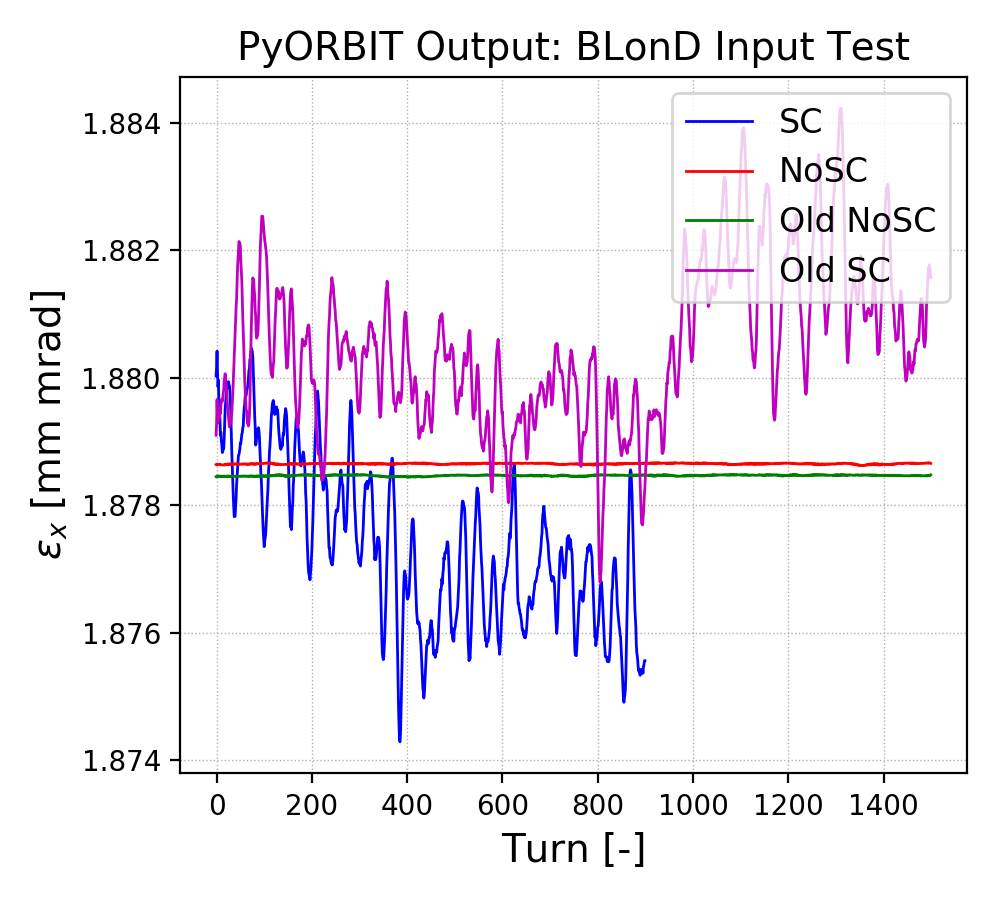

In [95]:
parameter1 = 'epsn_y'
multi1 = 1E6

fig, ax1 = plt.subplots();
ax1.set_title('PyORBIT Output: BLonD Input Test')

savename = parameter1 + '.png'

ax1.set_xlabel('Turn [-]')
ax1.set_ylabel('$\epsilon_x$ [mm mrad]')
    
ax1.plot(dd1['SC']['turn'][0], dd1['SC'][parameter1][0]*multi1, color='b', label='SC');
ax1.plot(dd1['NoSC']['turn'][0], dd1['NoSC'][parameter1][0]*multi1, color='r', label='NoSC');
ax1.plot(dd1['Old NoSC']['turn'][0], dd1['Old NoSC'][parameter1][0]*multi1, color='g', label='Old NoSC');
ax1.plot(dd1['Old SC']['turn'][0], dd1['Old SC'][parameter1][0]*multi1, color='m', label='Old SC');


ax1.legend(loc=1)
ax1.grid(which='both', ls=':', lw=0.5)

plt.tight_layout()
fig.savefig(savename)